In [1]:
import pandas as pd
from scipy.stats import binomtest
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use('ggplot')

In [2]:
df = pd.read_csv("comparison.csv", sep=" ")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   test_name            10261 non-null  object 
 1   task_name            10261 non-null  object 
 2   gold_standard_file   10261 non-null  object 
 3   coverage             10261 non-null  float64
 4   model                10261 non-null  object 
 5   model_configuration  10261 non-null  object 
 6   metric               10261 non-null  object 
 7   score_value          10261 non-null  float64
dtypes: float64(2), object(6)
memory usage: 641.4+ KB


In [3]:
def shorten_test_name(test_name):
    test_name_short = test_name.split('_')[1]
    
    return test_name_short[17:]

def get_embedding_type(test_name_short):
    breakdown = test_name_short.split('-')
    
    embedding_type = '-'.join(breakdown[0:-2])
    
    if embedding_type.startswith("non-rdf2vec-"):
        return embedding_type.replace("non-rdf2vec-", "")
    
    else:
        return str.upper(embedding_type).replace("RDF2VEC-", "RDF2vec$_{") + "}$"

def get_embedding_variant(test_name_short):
    breakdown = test_name_short.split('-')
    
    return  breakdown[-1].replace("autoencoded", "auto") + "-" + breakdown[-2]

df['test_name_short'] = df['test_name'].apply(shorten_test_name)
df['embedding_type'] = df['test_name_short'].apply(get_embedding_type)
df['embedding_variant'] = df['test_name_short'].apply(get_embedding_variant)

print(df['embedding_type'].unique())
print(df['embedding_variant'].unique())

['RDF2vec$_{CBOW}$' 'RDF2vec$_{CBOW-OA}$' 'RDF2vec$_{SG}$'
 'RDF2vec$_{SG-OA}$' 'ComplEx' 'DistMult' 'RESCAL' 'RotatE' 'TransE-L1'
 'TransE-L2' 'TransR']
['original-200' 'avgbin-200' 'auto-128' 'auto-256' 'auto-512']


In [4]:
df['gold_standard_file'] = df['gold_standard_file'].str.replace("_", "-")

dataset_lengths = { 
    "AAUP": 933,
    "Cities": 212,
    "Forbes": 1585,
    "MetacriticAlbums": 1592,
    "MetacriticMovies": 2000,
    "cities2000AndCountries-cluster": 4343,
    "citiesAndCountries-cluster": 11179,
    "citiesMoviesAlbumsCompaniesUni-cluster": 6322,
    "teams-cluster": 4206,
    "currency-entities": 58, 
    "city-state-entities": 94,
    "capital-country-entities": 46, 
    "all-capital-country-entities": 232,
}

## Classification

In [5]:
df_clf = df[
    (df['task_name']=='Classification') 
    & (df['metric']=='accuracy')
    & (df['coverage']>=0.5)
].drop(columns=['test_name'])
df_clf['rank'] = df_clf.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_clf_bestscores = df_clf[df_clf['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_clf_bestscores['gold_standard_file'].unique()

array(['MetacriticMovies', 'MetacriticAlbums', 'Forbes', 'Cities', 'AAUP'],
      dtype=object)

In [6]:
def get_acc_loss(gold_standard_file, score_value, embedding_type):
    p = df_clf_bestscores[
        (df_clf_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_clf_bestscores["embedding_type"]==embedding_type)
        & (df_clf_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return p - score_value


def calculate_pvalue_clf(gold_standard_file, score_value, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*score_value)
    p = get_acc_loss(gold_standard_file, score_value, embedding_type) + score_value

    return binomtest(successes, n, p, alternative='less').pvalue
    
df_clf_bestscores["acc_loss"] = df_clf_bestscores.apply(
    lambda x: get_acc_loss(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_clf_bestscores["pvalue_worse_than_original"] = df_clf_bestscores.apply(
    lambda x: calculate_pvalue_clf(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_clf_bestscores["not_worse_than_original"] = df_clf_bestscores["pvalue_worse_than_original"] >= alpha

df_clf_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,2.160000e+02,216.000000
mean,9.853969e-02,0.034573
std,1.631323e-01,0.026643
min,3.793150e-14,-0.017690
25%,1.158143e-03,0.018369
50%,1.729069e-02,0.031290
75%,1.207182e-01,0.044977
max,9.270287e-01,0.188703


In [7]:
def reorganize_latex_table(latex_table):
    latex_table_split = latex_table.split("\n")
    
    latex_table_split[0] += "[h!]"
    caption = latex_table_split.pop(2)
    label = latex_table_split.pop(2)
    end_string = latex_table_split.pop(-1)
    end_table = latex_table_split.pop(-1)

    latex_table_split.extend([caption, label, end_table, end_string])
    return "\n".join(latex_table_split)


def highlight_best_scores(latex_table, max_value=True):
    latex_table_split = latex_table.split("\n")
    highlighted_latex_table_split = []

    for line in latex_table_split:
        line_split = line.strip("\\").split("&")
        if len(line_split) >= 4:
            line_values = []
            for value in line_split:
                if value.strip().replace(".", "").isnumeric():
                    line_values.append(float(value.strip())) 
            if len(line_values) >= 4:
                line_max_value = max(line_values) if max_value else min(line_values)
                line_formatted = []
                for value in line_split: 
                    value_numeric = float(value.strip()) if value.strip().replace(".", "").isnumeric() else 0.0
                    new_value = "\t\\textbf{" + value.strip() + "}" if value_numeric==line_max_value else value
                    line_formatted.append(new_value)
                if len(line_formatted)>0:
                    highlighted_latex_table_split.append(" &".join(line_formatted) + " \\" + "\\")
            else:
                highlighted_latex_table_split.append(line)
        else:
                highlighted_latex_table_split.append(line)
    return "\n".join(highlighted_latex_table_split)

example = """\begin{table}
\centering
\caption{Count of GEval classification datasets in which the best classifier of each binary embedding variant did not significantly underperfom the original one in accuracy. The closer to 5, the less is the performance loss. $\alpha=0.05$.}
\label{tab:clf-acc-significantly-not-worse}
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
ComplEx             &           0 &         0 &         0 &         1 \\
DistMult            &           1 &         0 &         1 &         1 \\
RDF2vec$_{CBOW-OA}$ &           3 &         2 &         2 &         2 \\
RDF2vec$_{CBOW}$    &           4 &         1 &         4 &         2 \\
RDF2vec$_{SG-OA}$   &           1 &         4 &         3 &         4 \\
RDF2vec$_{SG}$      &           2 &         1 &         2 &         4 \\
RESCAL              &           2 &         3 &         3 &         2 \\
RotatE              &           1 &         0 &         1 &         2 \\
TransE-L1           &           2 &         3 &         4 &         4 \\
TransE-L2           &           1 &         1 &         1 &         3 \\
TransR              &           1 &         2 &         1 &         1 \\
\bottomrule
\end{tabular}
\end{table}"""


print(highlight_best_scores(reorganize_latex_table(example)))

egin{table}[h!]
\centering
egin{tabular}{lrrrr}
	oprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \
\midrule
ComplEx              &           0  &         0  &         0  &	\textbf{1} \\
DistMult             &	\textbf{1} &         0  &	\textbf{1} &	\textbf{1} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{3} &         2  &         2  &         2  \\
RDF2vec$_{CBOW}$     &	\textbf{4} &         1  &	\textbf{4} &         2  \\
RDF2vec$_{SG-OA}$    &           1  &	\textbf{4} &         3  &	\textbf{4} \\
RDF2vec$_{SG}$       &           2  &         1  &         2  &	\textbf{4} \\
RESCAL               &           2  &	\textbf{3} &	\textbf{3} &         2  \\
RotatE               &           1  &         0  &         1  &	\textbf{2} \\
TransE-L1            &           2  &         3  &	\textbf{4} &	\textbf{4} \\
TransE-L2            &           1  &         1  &         1  &	\textbf{3} \\
TransR               &           1  &	\textbf{2} &         1  &         1  \\
ottomrule
\caption{Count 

In [8]:
caption="Count of GEval classification datasets in which the best classifier " + \
    "of each binary embedding variant did not significantly underperfom the original one in accuracy. " + \
    "The closer to 5, the less is the performance loss. $\\alpha=0.05$."

df_clf_sig_not_worst = pd.pivot_table(
    df_clf_bestscores[df_clf_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
)

print(caption) 
print(r"in table \ref{tab:geval-clf-acc-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_clf_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-clf-acc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_clf_sig_not_worst.mean())

df_clf_sig_not_worst

Count of GEval classification datasets in which the best classifier of each binary embedding variant did not significantly underperfom the original one in accuracy. The closer to 5, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-clf-acc-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
ComplEx              &           0  &         0  &         0  &	\textbf{1} \\
DistMult             &	\textbf{1} &         0  &	\textbf{1} &	\textbf{1} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{3} &         2  &         2  &         2  \\
RDF2vec$_{CBOW}$     &	\textbf{4} &         1  &	\textbf{4} &         2  \\
RDF2vec$_{SG-OA}$    &           1  &	\textbf{4} &         3  &	\textbf{4} \\
RDF2vec$_{SG}$       &           2  &         1  &         2  &	\textbf{4} \\
RESCAL               &           2  &	\textbf{3} &	\textbf{3} &         2  \\
RotatE               &           1  &        

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
ComplEx,0,0,1,0
DistMult,0,1,1,1
RDF2vec$_{CBOW-OA}$,2,2,2,3
RDF2vec$_{CBOW}$,1,4,2,4
RDF2vec$_{SG-OA}$,4,3,4,1
RDF2vec$_{SG}$,1,2,4,2
RESCAL,3,3,2,2
RotatE,0,1,2,1
TransE-L1,3,4,4,2


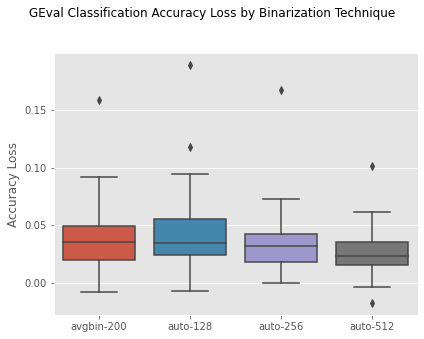

GEval classification accuracy loss by binarization technique in Figure \ref{fig:geval-clf-acc-loss}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clf-acc-loss.png}}
    \caption{GEval Classification Accuracy Loss by Binarization Technique}
    \label{fig:geval-clf-acc-loss}
\end{figure}


In [9]:
g = sns.catplot(
    data=df_clf_bestscores[df_clf_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Accuracy Loss")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('GEval Classification Accuracy Loss by Binarization Technique')

plt.savefig("images/geval-clf-acc-loss.png")

plt.show()
    
print("GEval classification accuracy loss by binarization technique in Figure \\ref{fig:geval-clf-acc-loss}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clf-acc-loss.png}}")
print("    \caption{GEval Classification Accuracy Loss by Binarization Technique}")
print("    \label{fig:geval-clf-acc-loss}")
print("\end{figure}")

In [10]:
def get_latex_table_clf_acc(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_clf_bestscores[df_clf_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).sort_values(by="original-200", ascending=False).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-clf-acc-{gold_standard_file_lower}",
        caption=f"Accuracy scores for best classifier of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    return highlight_best_scores(reorganize_latex_table(latex_table))

\subsubsection{MetacriticMovies Dataset}
\label{subsubsec:geval-results-clf-metacriticmovies} 

GEval Classification Accuracy Loss for MetacriticMovies Dataset in Figure \ref{fig:geval-clf-acc-loss-metacriticmovies}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-clf-acc-loss-metacriticmovies.png}
    \caption{GEval Classification Accuracy Loss for MetacriticMovies Dataset}
    \label{fig:geval-clf-acc-loss-metacriticmovies}
\end{figure}



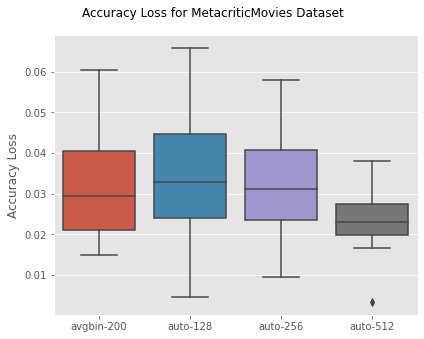

Accuracy scores for MetacriticMovies Dataset in table \ref{tab:geval-clf-acc-metacriticmovies}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{0.754} &       0.712  &     0.695  &     0.709  &     0.729  \\
RDF2vec$_{SG}$       &	\textbf{0.713} &       0.689  &     0.680  &     0.690  &     0.710  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.712} &       0.677  &     0.696  &     0.680  &     0.692  \\
TransR               &	\textbf{0.710} &       0.671  &     0.675  &     0.670  &     0.688  \\
ComplEx              &	\textbf{0.695} &       0.646  &     0.642  &     0.664  &     0.679  \\
RESCAL               &	\textbf{0.683} &       0.664  &     0.678  &     0.672  &     0.654  \\
DistMult             &	\textbf{0.673} &       0.613  &     0.637  &     0.650  &     0.648  \\
TransE-L1            &	\textbf{0.640} &       0.610  &     0.574  &     0.582  &     0.602  \\

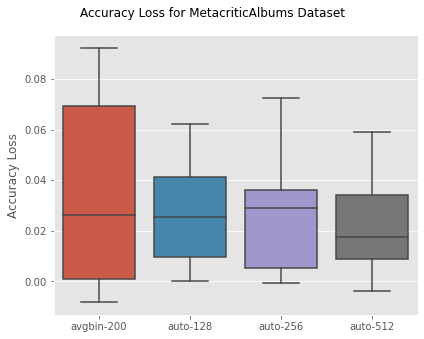

Accuracy scores for MetacriticAlbums Dataset in table \ref{tab:geval-clf-acc-metacriticalbums}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{0.660} &       0.635  &     0.634  &     0.630  &     0.646  \\
DistMult             &	\textbf{0.630} &       0.538  &     0.571  &     0.588  &     0.584  \\
ComplEx              &	\textbf{0.628} &       0.548  &     0.600  &     0.599  &     0.606  \\
TransE-L1            &	\textbf{0.622} &       0.596  &     0.610  &     0.614  &     0.604  \\
RESCAL               &	\textbf{0.620} &       0.561  &     0.578  &     0.588  &     0.586  \\
TransR               &	\textbf{0.616} &       0.537  &     0.554  &     0.544  &     0.558  \\
RDF2vec$_{SG}$       &         0.582  &	\textbf{0.583} &     0.582  &	\textbf{0.583} &     0.582  \\
RDF2vec$_{SG-OA}$    &         0.581  &       0.580  &     0.575  &	\textbf{0.582} &    

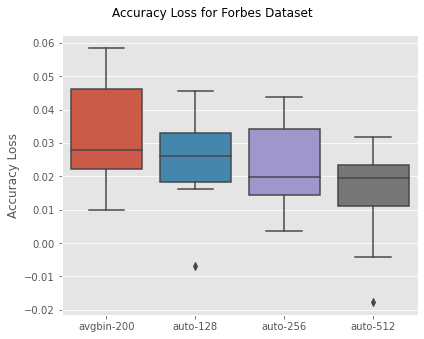

Accuracy scores for Forbes Dataset in table \ref{tab:geval-clf-acc-forbes}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{SG}$       &         0.625  &       0.599  &     0.592  &     0.614  &	\textbf{0.629} \\
TransE-L2            &	\textbf{0.603} &       0.593  &     0.587  &     0.584  &     0.592  \\
RDF2vec$_{SG-OA}$    &         0.595  &       0.570  &     0.602  &     0.585  &	\textbf{0.613} \\
RESCAL               &	\textbf{0.594} &       0.546  &     0.566  &     0.563  &     0.573  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.591} &       0.555  &     0.573  &     0.551  &     0.568  \\
ComplEx              &	\textbf{0.569} &       0.541  &     0.536  &     0.538  &     0.545  \\
TransR               &	\textbf{0.568} &       0.509  &     0.549  &     0.531  &     0.536  \\
RDF2vec$_{CBOW}$     &	\textbf{0.565} &       0.551  &     0.541  &     0.562  &     0.554  \\
TransE-L1  

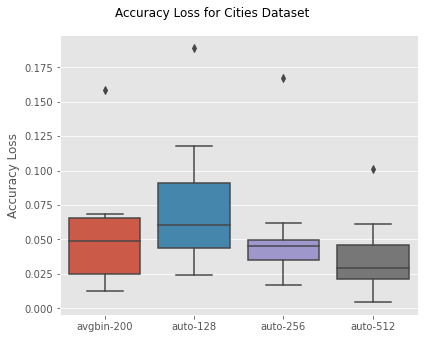

Accuracy scores for Cities Dataset in table \ref{tab:geval-clf-acc-cities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{0.806} &       0.751  &     0.747  &     0.757  &     0.760  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.785} &       0.717  &     0.754  &     0.759  &     0.757  \\
TransR               &	\textbf{0.748} &       0.728  &     0.705  &     0.699  &     0.725  \\
RESCAL               &	\textbf{0.745} &       0.732  &     0.699  &     0.707  &     0.740  \\
ComplEx              &	\textbf{0.735} &       0.577  &     0.546  &     0.568  &     0.634  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.716} &       0.678  &     0.635  &     0.699  &     0.685  \\
RDF2vec$_{CBOW}$     &	\textbf{0.703} &       0.686  &     0.585  &     0.668  &     0.641  \\
TransE-L1            &	\textbf{0.679} &       0.611  &     0.654  &     0.631  &     0.635  \\
DistMult           

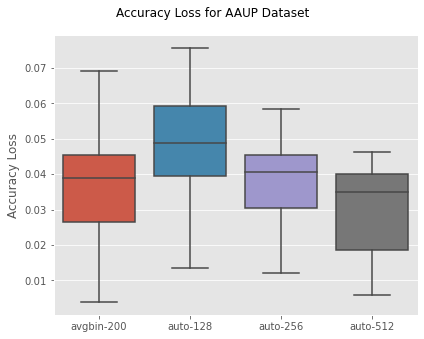

Accuracy scores for AAUP Dataset in table \ref{tab:geval-clf-acc-aaup}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{SG-OA}$    &	\textbf{0.705} &       0.666  &     0.650  &     0.664  &     0.685  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.688} &       0.638  &     0.612  &     0.637  &     0.641  \\
RDF2vec$_{SG}$       &	\textbf{0.687} &       0.670  &     0.632  &     0.638  &     0.681  \\
TransE-L2            &	\textbf{0.658} &       0.626  &     0.611  &     0.618  &     0.628  \\
RESCAL               &	\textbf{0.643} &       0.639  &     0.630  &     0.631  &     0.627  \\
RDF2vec$_{CBOW}$     &	\textbf{0.630} &       0.597  &     0.562  &     0.571  &     0.589  \\
TransE-L1            &	\textbf{0.630} &       0.609  &     0.606  &     0.616  &     0.618  \\
TransR               &	\textbf{0.629} &       0.582  &     0.597  &     0.589  &     0.594  \\
DistMult             &	

In [11]:
for gold_standard_file in df_clf_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-clf-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_clf_bestscores[
            (df_clf_bestscores["embedding_variant"]!="original-200")
            & (df_clf_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Accuracy Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Accuracy Loss for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-clf-acc-loss-{dataset_lower}.png")

    print("GEval Classification Accuracy Loss for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-clf-acc-loss-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-clf-acc-loss-"+dataset_lower+".png}")
    print("    \caption{GEval Classification Accuracy Loss for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-clf-acc-loss-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("Accuracy scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-clf-acc-"+dataset_lower+"}.\n\n")


    print(get_latex_table_clf_acc(gold_standard_file))



## Clustering

In [12]:
df_clt = df[
    (df['task_name']=='Clustering') 
    & (df['metric']=='clustering_accuracy')
    & (df['coverage']>=0.5)
].drop(columns=['test_name'])
df_clt['rank'] = df_clt.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_clt_bestscores = df_clt[df_clt['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_clt_bestscores['gold_standard_file'].unique()

array(['teams-cluster', 'citiesMoviesAlbumsCompaniesUni-cluster',
       'citiesAndCountries-cluster', 'cities2000AndCountries-cluster'],
      dtype=object)

In [13]:
def get_acc_loss(gold_standard_file, score_value, embedding_type):
    p = df_clt_bestscores[
        (df_clt_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_clt_bestscores["embedding_type"]==embedding_type)
        & (df_clt_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return p - score_value


def calculate_pvalue_clt(gold_standard_file, score_value, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*score_value)
    p = get_acc_loss(gold_standard_file, score_value, embedding_type) + score_value

    return binomtest(successes, n, p, alternative='less').pvalue
    
df_clt_bestscores["acc_loss"] = df_clt_bestscores.apply(
    lambda x: get_acc_loss(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_clt_bestscores["pvalue_worse_than_original"] = df_clt_bestscores.apply(
    lambda x: calculate_pvalue_clt(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_clt_bestscores["not_worse_than_original"] = df_clt_bestscores["pvalue_worse_than_original"] >= alpha

df_clt_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,1.760000e+02,176.000000
mean,3.085032e-01,0.006925
std,3.763818e-01,0.080058
min,0.000000e+00,-0.333648
25%,3.107083e-10,0.000000
50%,8.805556e-02,0.005820
75%,5.092334e-01,0.027004
max,1.000000e+00,0.331669


In [14]:
caption="Count of GEval clustering datasets in which the best clusterer of each binary " + \
    "embedding variant did not significantly underperfom the original one in clustering accuracy. " + \
    "The closer to 4, the less is the performance loss. $\\alpha=0.05$."

df_clt_sig_not_worst = pd.pivot_table(
    df_clt_bestscores[df_clt_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
)

print(caption)
print(r"in table \ref{tab:geval-clt-acc-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_clt_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-clt-acc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_clt_sig_not_worst.mean())

df_clt_sig_not_worst

Count of GEval clustering datasets in which the best clusterer of each binary embedding variant did not significantly underperfom the original one in clustering accuracy. The closer to 4, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-clt-acc-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
ComplEx              &	\textbf{2} &         1  &         1  &	\textbf{2} \\
DistMult             &           1  &         1  &         2  &	\textbf{3} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{4} &	\textbf{4} &	\textbf{4} &	\textbf{4} \\
RDF2vec$_{CBOW}$     &	\textbf{2} &	\textbf{2} &	\textbf{2} &	\textbf{2} \\
RDF2vec$_{SG-OA}$    &           2  &         2  &	\textbf{4} &         3  \\
RDF2vec$_{SG}$       &           2  &         3  &	\textbf{4} &	\textbf{4} \\
RESCAL               &	\textbf{1} &         0  &	\textbf{1} &	\textbf{1} \\
RotatE               &	\textbf{2} &      

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
ComplEx,1,1,2,2
DistMult,1,2,3,1
RDF2vec$_{CBOW-OA}$,4,4,4,4
RDF2vec$_{CBOW}$,2,2,2,2
RDF2vec$_{SG-OA}$,2,4,3,2
RDF2vec$_{SG}$,3,4,4,2
RESCAL,0,1,1,1
RotatE,0,2,1,2
TransE-L1,1,1,2,2


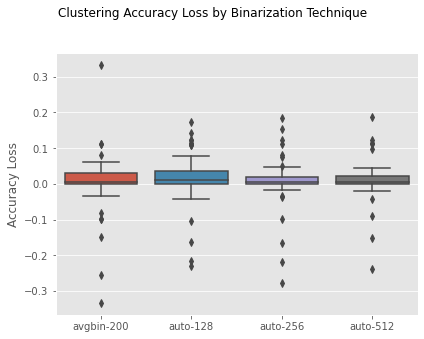

Clustering accuracy loss by binarization technique in Figure \ref{fig:geval-clt-acc-loss}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clt-acc-loss.png}}
    \caption{GEval Clustering Accuracy Loss by Binarization Technique}
    \label{fig:geval-clt-acc-loss}
\end{figure}


In [15]:
g = sns.catplot(
    data=df_clt_bestscores[df_clt_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Accuracy Loss")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Clustering Accuracy Loss by Binarization Technique')

plt.savefig("images/geval-clt-acc-loss.png")

plt.show()
    
print("Clustering accuracy loss by binarization technique in Figure \\ref{fig:geval-clt-acc-loss}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clt-acc-loss.png}}")
print("    \caption{GEval Clustering Accuracy Loss by Binarization Technique}")
print("    \label{fig:geval-clt-acc-loss}")
print("\end{figure}")

In [16]:
def get_latex_table_clt_acc(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_clt_bestscores[df_clt_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).sort_values(by="original-200", ascending=False).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-clt-acc-{gold_standard_file_lower}",
        caption=f"Clustering accuracy scores for best clusterer of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

\subsubsection{teams-cluster Dataset}
\label{subsubsec:geval-results-clt-teams-cluster} 

GEval Clustering Accuracy Loss for teams-cluster Dataset in Figure \ref{fig:geval-clt-acc-loss-teams-cluster}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-clt-acc-loss-teams-cluster.png}
    \caption{GEval Clustering Accuracy Loss for teams-cluster Dataset}
    \label{fig:geval-clt-acc-loss-teams-cluster}
\end{figure}



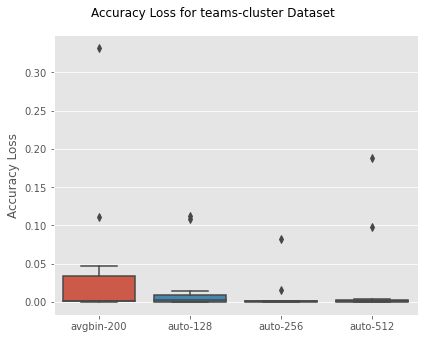

Accuracy scores for teams-cluster Dataset in table \ref{tab:geval-clt-acc-teams-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.942} &       0.610  &     0.830  &     0.860  &     0.754  \\
ComplEx              &	\textbf{0.942} &       0.941  &     0.939  &	\textbf{0.942} &	\textbf{0.942} \\
DistMult             &	\textbf{0.942} &       0.830  &     0.940  &	\textbf{0.942} &     0.938  \\
RotatE               &	\textbf{0.942} &       0.920  &     0.833  &     0.941  &     0.844  \\
TransE-L2            &	\textbf{0.942} &	\textbf{0.942} &	\textbf{0.942} &	\textbf{0.942} &	\textbf{0.942} \\
TransR               &	\textbf{0.942} &       0.941  &     0.937  &     0.940  &     0.941  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.941} &	\textbf{0.941} &     0.940  &	\textbf{0.941} &	\textbf{0.941} \\
RDF2vec$_{SG-OA}$    &	\textbf{0.941} &	\textbf{0.941} &	\textbf

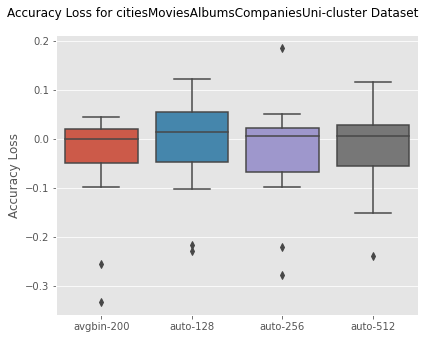

Accuracy scores for citiesMoviesAlbumsCompaniesUni-cluster Dataset in table \ref{tab:geval-clt-acc-citiesmoviesalbumscompaniesuni-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &         0.906  &	\textbf{0.907} &     0.898  &     0.900  &     0.898  \\
TransE-L1            &	\textbf{0.901} &       0.885  &     0.887  &     0.884  &     0.888  \\
RESCAL               &	\textbf{0.894} &       0.871  &     0.863  &     0.867  &     0.852  \\
DistMult             &         0.861  &       0.862  &     0.848  &     0.877  &	\textbf{0.881} \\
ComplEx              &         0.859  &	\textbf{0.860} &     0.736  &     0.808  &     0.853  \\
RDF2vec$_{SG-OA}$    &         0.854  &       0.819  &     0.740  &	\textbf{0.891} &     0.811  \\
RotatE               &	\textbf{0.762} &       0.718  &     0.685  &     0.577  &     0.647  \\
RDF2vec$_{SG}$       &	\textbf{0.749} 

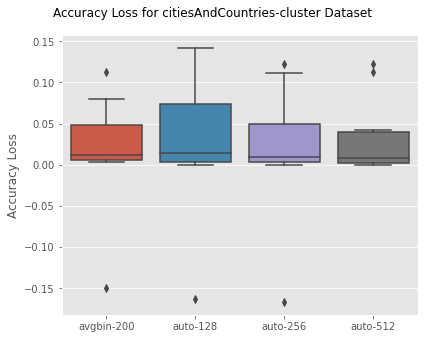

Accuracy scores for citiesAndCountries-cluster Dataset in table \ref{tab:geval-clt-acc-citiesandcountries-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{0.939} &       0.936  &     0.925  &     0.930  &     0.931  \\
TransE-L1            &	\textbf{0.930} &       0.925  &     0.919  &     0.921  &     0.894  \\
RESCAL               &	\textbf{0.928} &       0.867  &     0.786  &     0.854  &     0.885  \\
TransR               &	\textbf{0.917} &       0.907  &     0.878  &     0.905  &     0.909  \\
ComplEx              &	\textbf{0.909} &       0.874  &     0.787  &     0.787  &     0.787  \\
DistMult             &	\textbf{0.896} &       0.783  &     0.787  &     0.785  &     0.784  \\
RotatE               &	\textbf{0.787} &       0.782  &     0.780  &     0.781  &     0.782  \\
RDF2vec$_{CBOW-OA}$  &         0.785  &       0.935  &     0.948  &	\textb

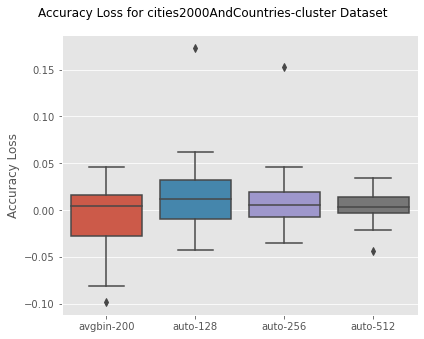

Accuracy scores for cities2000AndCountries-cluster Dataset in table \ref{tab:geval-clt-acc-cities2000andcountries-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{0.940} &       0.894  &     0.932  &     0.934  &     0.934  \\
RESCAL               &	\textbf{0.933} &       0.928  &     0.921  &     0.930  &     0.908  \\
TransE-L1            &	\textbf{0.932} &       0.927  &     0.919  &     0.925  &     0.929  \\
TransR               &	\textbf{0.921} &       0.916  &     0.915  &     0.898  &     0.904  \\
RDF2vec$_{SG-OA}$    &         0.900  &	\textbf{0.922} &     0.728  &     0.916  &     0.921  \\
ComplEx              &	\textbf{0.897} &       0.861  &     0.835  &     0.851  &     0.863  \\
RDF2vec$_{CBOW-OA}$  &         0.894  &       0.928  &     0.937  &     0.929  &	\textbf{0.938} \\
DistMult             &         0.868  &       0.841  &     0

In [17]:
for gold_standard_file in df_clt_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-clt-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_clt_bestscores[
            (df_clt_bestscores["embedding_variant"]!="original-200")
            & (df_clt_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Accuracy Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Accuracy Loss for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-clt-acc-loss-{dataset_lower}.png")

    print("GEval Clustering Accuracy Loss for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-clt-acc-loss-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-clt-acc-loss-"+dataset_lower+".png}")
    print("    \caption{GEval Clustering Accuracy Loss for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-clt-acc-loss-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("Accuracy scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-clt-acc-"+dataset_lower+"}.\n\n")


    print(get_latex_table_clt_acc(gold_standard_file))

## Regression

In [18]:
reg_dataset_folder = "evaluation_framework/Regression/data"
reg_gold_standard_files = [
    'AAUP',
    'Cities', 
    'Forbes', 
    'MetacriticAlbums', 
    'MetacriticMovies',
]
reg_gold_standard_stats = []

for reg_gold_standard_file in reg_gold_standard_files:
    stats = pd.read_csv(
        f"{reg_dataset_folder}/{reg_gold_standard_file}.tsv", 
        sep='\t',
    )["rating"].describe().to_dict()
    stats["iqr"] = stats["75%"] - stats["25%"]
    stats["range"] = stats["max"] - stats["min"]
    stats["gold_standard_file"] = reg_gold_standard_file
    reg_gold_standard_stats.append(stats)

pd.DataFrame(reg_gold_standard_stats)

,count,mean,std,min,25%,50%,75%,max,iqr,range,gold_standard_file
0,960.0,421.596875,94.256483,232.0,350.000,409.00,478.0,866.0,128.000,634.0,AAUP
1,212.0,76.021226,22.316514,23.0,57.875,77.25,99.0,106.0,41.125,83.0,Cities
2,1585.0,21.913754,36.017010,0.0,6.200,10.80,21.8,416.6,15.600,416.6,Forbes
3,1600.0,69.873125,13.951566,15.0,58.000,71.00,82.0,97.0,24.000,82.0,MetacriticAlbums
4,2000.0,51.223000,22.938774,1.0,32.000,50.00,71.0,100.0,39.000,99.0,MetacriticMovies


In [19]:
reg_gold_standard_ranges = {}
for stats in reg_gold_standard_stats:
    reg_gold_standard_ranges[stats["gold_standard_file"]] = stats["range"]

reg_gold_standard_ranges

{'AAUP': 634.0,
 'Cities': 83.0,
 'Forbes': 416.6,
 'MetacriticAlbums': 82.0,
 'MetacriticMovies': 99.0}

In [20]:
df_reg = df[
    (df['task_name']=='Regression') 
    & (df['metric']=='root_mean_squared_error')
    & (df['coverage']>=0.5)
].drop(columns=['test_name'])
df_reg['rank'] = df_reg.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=True,
)
df_reg_bestscores = df_reg[df_reg['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=True
)

df_reg_bestscores['gold_standard_file'].unique()

array(['AAUP', 'Cities', 'Forbes', 'MetacriticAlbums', 'MetacriticMovies'],
      dtype=object)

In [21]:
df_reg_bestscores['nrmse'] = df_reg_bestscores['score_value'] / df_reg_bestscores['gold_standard_file'].map(
    reg_gold_standard_ranges
)
 
df_reg_bestscores['nrmse'].describe()

count    270.000000
mean       0.168645
std        0.055821
min        0.079649
25%        0.116285
50%        0.178505
75%        0.217955
max        0.273475
Name: nrmse, dtype: float64

In [22]:
def get_nrmse_gain(gold_standard_file, nrmse, embedding_type):
    nrmse_original = df_reg_bestscores[
        (df_reg_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_reg_bestscores["embedding_type"]==embedding_type)
        & (df_reg_bestscores["embedding_variant"]=="original-200")
    ]["nrmse"].iloc[0]
    
    return nrmse - nrmse_original

def calculate_pvalue_reg(gold_standard_file, nrmse, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*(1-nrmse))

    nrmse_original = nrmse - get_nrmse_gain(gold_standard_file, nrmse, embedding_type)

    return binomtest(successes, n, 1 - nrmse_original, alternative='less').pvalue
    
df_reg_bestscores["nrmse_gain"] = df_reg_bestscores.apply(
    lambda x: get_nrmse_gain(
        x.gold_standard_file, 
        x.nrmse, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_reg_bestscores["pvalue_worse_than_original"] = df_reg_bestscores.apply(
    lambda x: calculate_pvalue_reg(
        x.gold_standard_file, 
        x.nrmse, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_reg_bestscores["not_worse_than_original"] = df_reg_bestscores["pvalue_worse_than_original"] >= alpha

df_reg_bestscores[["pvalue_worse_than_original", "nrmse_gain"]].describe()

,pvalue_worse_than_original,nrmse_gain
count,216.000000,216.000000
mean,0.333304,0.007871
std,0.256447,0.013581
min,0.000039,-0.023939
25%,0.088880,-0.000393
50%,0.326922,0.005102
75%,0.534022,0.015662
max,0.981216,0.080759


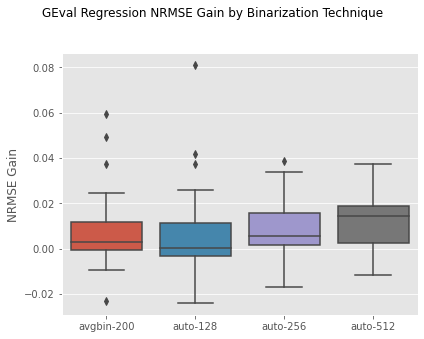

GEval regression NRMSE gain by binarization technique in Figure \ref{fig:geval-reg-nrmse-gain}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-reg-nrmse-gain.png}}
    \caption{GEval Regression NRMSE Gain by Binarization Technique}
    \label{fig:geval-reg-nrmse-gain}
\end{figure}


In [23]:
g = sns.catplot(
    data=df_reg_bestscores[df_reg_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="nrmse_gain",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "NRMSE Gain")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('GEval Regression NRMSE Gain by Binarization Technique')

plt.savefig("images/geval-reg-nrmse-gain.png")

plt.show()
    
print("GEval regression NRMSE gain by binarization technique in Figure \\ref{fig:geval-reg-nrmse-gain}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-reg-nrmse-gain.png}}")
print("    \caption{GEval Regression NRMSE Gain by Binarization Technique}")
print("    \label{fig:geval-reg-nrmse-gain}")
print("\end{figure}")

In [24]:
def get_latex_table_reg_rmse(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_reg_bestscores[df_reg_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="min",
    ).sort_values(by="original-200", ascending=True).to_latex(
        float_format="%.2f",
        escape=False,
        index_names=False,
        label=f"tab:geval-reg-rmse-{gold_standard_file_lower}",
        caption=f"RMSE scores for best regressor of each embedding variant in dataset {gold_standard_file}.",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table), max_value=False)

\subsubsection{AAUP Dataset}
\label{subsubsec:geval-results-reg-aaup} 

GEval Regression NRMSE Gain for AAUP Dataset in Figure \ref{fig:geval-reg-nrmse-gain-aaup}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-reg-nrmse-gain-aaup.png}
    \caption{GEval Regression NRMSE Gain for AAUP Dataset}
    \label{fig:geval-reg-nrmse-gain-aaup}
\end{figure}



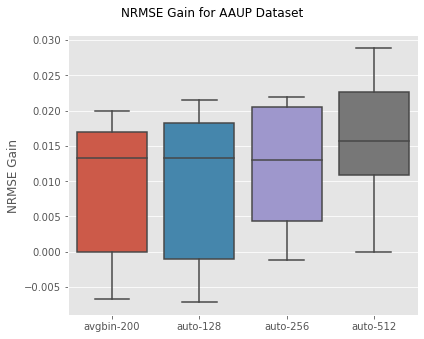

RMSE scores for AAUP Dataset in table \ref{tab:geval-reg-rmse-aaup}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{SG-OA}$    &	\textbf{65.15} &       73.55  &     78.80  &     79.07  &     74.90  \\
TransE-L2            &	\textbf{65.41} &       72.99  &     77.87  &     73.69  &     70.03  \\
RDF2vec$_{SG}$       &         65.64  &	\textbf{61.41} &     64.05  &     66.33  &     65.62  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{67.45} &       79.40  &     79.72  &     80.61  &     78.42  \\
RESCAL               &	\textbf{69.36} &       78.41  &     75.18  &     75.81  &     79.27  \\
DistMult             &	\textbf{73.82} &       86.43  &     83.43  &     87.46  &     92.06  \\
ComplEx              &	\textbf{76.76} &       88.78  &     85.23  &     86.93  &     91.80  \\
RDF2vec$_{CBOW}$     &	\textbf{78.37} &       87.96  &     89.26  &     91.16  &     87.59  \\
TransE-L1            &  

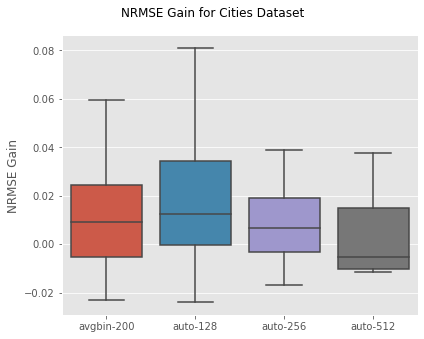

RMSE scores for Cities Dataset in table \ref{tab:geval-reg-rmse-cities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &         12.75  &       12.46  &     14.90  &     13.82  &	\textbf{12.33} \\
RDF2vec$_{SG-OA}$    &         13.38  &       15.31  &     13.32  &     13.20  &	\textbf{12.89} \\
TransR               &	\textbf{13.60} &       14.47  &     14.49  &     14.79  &     15.02  \\
ComplEx              &	\textbf{15.85} &       20.80  &     22.56  &     19.07  &     18.96  \\
RESCAL               &         16.72  &	\textbf{14.81} &     16.72  &     16.44  &     15.87  \\
TransE-L1            &	\textbf{17.12} &       19.17  &     20.21  &     19.52  &     18.42  \\
DistMult             &	\textbf{18.16} &       22.24  &     21.63  &     19.88  &     19.21  \\
RDF2vec$_{CBOW}$     &         19.64  &       19.15  &     19.02  &	\textbf{18.24} &     18.69  \\
RDF2vec$

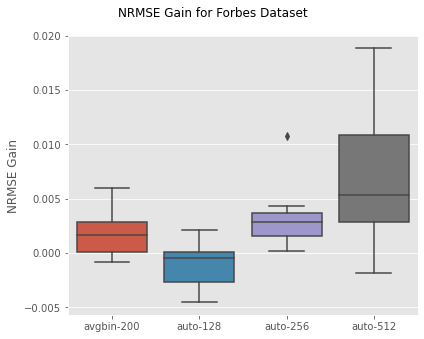

RMSE scores for Forbes Dataset in table \ref{tab:geval-reg-rmse-forbes}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{SG}$       &         33.97  &       34.83  &     34.73  &     34.02  &	\textbf{33.18} \\
ComplEx              &	\textbf{36.26} &       37.91  &     37.12  &     40.73  &     38.89  \\
RESCAL               &         36.84  &       38.37  &	\textbf{36.64} &     37.59  &     37.63  \\
TransE-L2            &         36.95  &       36.95  &	\textbf{36.80} &     38.05  &     44.80  \\
RDF2vec$_{SG-OA}$    &	\textbf{37.06} &       37.83  &     37.07  &     38.24  &     37.92  \\
DistMult             &	\textbf{37.31} &       39.81  &     37.40  &     39.07  &     39.01  \\
RDF2vec$_{CBOW-OA}$  &         37.81  &       37.85  &	\textbf{37.08} &     39.63  &     39.34  \\
TransE-L1            &         37.93  &       38.03  &	\textbf{36.72} &     39.17  &     44.34  \\
Tr

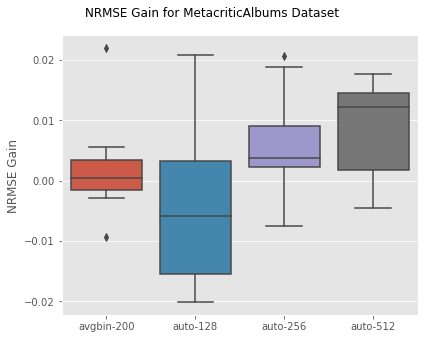

RMSE scores for MetacriticAlbums Dataset in table \ref{tab:geval-reg-rmse-metacriticalbums}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{13.88} &       14.34  &     14.14  &     14.83  &     15.11  \\
DistMult             &	\textbf{14.29} &       16.09  &     14.58  &     15.99  &     15.63  \\
ComplEx              &	\textbf{14.41} &       14.75  &     16.11  &     15.95  &     15.85  \\
TransR               &         14.66  &       14.70  &	\textbf{14.47} &     15.21  &     15.81  \\
RESCAL               &	\textbf{14.75} &       14.83  &     15.79  &     15.04  &     15.75  \\
TransE-L1            &         14.83  &       14.79  &	\textbf{14.35} &     15.08  &     15.97  \\
RotatE               &         15.03  &       15.04  &	\textbf{14.54} &     15.53  &     15.87  \\
RDF2vec$_{SG}$       &         15.61  &       15.83  &	\textbf{14.39} &     15.74  & 

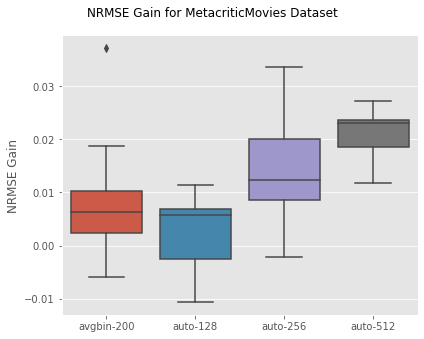

RMSE scores for MetacriticMovies Dataset in table \ref{tab:geval-reg-rmse-metacriticmovies}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{19.88} &       20.89  &     21.01  &     21.57  &     21.31  \\
RDF2vec$_{SG}$       &	\textbf{20.51} &       21.13  &     21.07  &     22.01  &     23.04  \\
RDF2vec$_{SG-OA}$    &	\textbf{20.57} &       21.60  &     21.17  &     21.80  &     22.38  \\
TransR               &	\textbf{20.80} &       21.66  &     21.51  &     21.87  &     23.12  \\
ComplEx              &	\textbf{21.16} &       23.02  &     22.19  &     23.44  &     23.03  \\
DistMult             &	\textbf{21.40} &       25.08  &     22.05  &     24.74  &     23.77  \\
RESCAL               &         21.67  &       22.23  &	\textbf{21.58} &     24.22  &     24.36  \\
TransE-L1            &	\textbf{22.99} &       23.16  &	\textbf{22.99} &     23.91  &     25.3

In [25]:
for gold_standard_file in df_reg_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-reg-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_reg_bestscores[
            (df_reg_bestscores["embedding_variant"]!="original-200")
            & (df_reg_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="nrmse_gain",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "NRMSE Gain")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'NRMSE Gain for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-reg-nrmse-gain-{dataset_lower}.png")

    print("GEval Regression NRMSE Gain for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-reg-nrmse-gain-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-reg-nrmse-gain-"+dataset_lower+".png}")
    print("    \caption{GEval Regression NRMSE Gain for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-reg-nrmse-gain-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("RMSE scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-reg-rmse-"+dataset_lower+"}.\n\n")


    print(get_latex_table_reg_rmse(gold_standard_file))

## Document Similarity

In [26]:
df_docsim = df[
    (df['task_name']=='DocumentSimilarity') 
    & (df['metric']=='harmonic_mean')
    & (df['coverage']>=0.5)
].drop(columns=['test_name'])
df_docsim['rank'] = df_docsim.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_docsim_bestscores = df_docsim[df_docsim['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_docsim_bestscores['gold_standard_file'].unique()

array(['LP50'], dtype=object)

In [27]:
df_docsim_bestscores

,gold_standard_file,coverage,model,model_configuration,metric,score_value,test_name_short,embedding_type,embedding_variant
128,LP50,0.945141,with_weights,-,harmonic_mean,0.510978,non-rdf2vec-TransR-200-avgbin,TransR,avgbin-200
62,LP50,0.945141,with_weights,-,harmonic_mean,0.505859,non-rdf2vec-TransR-200-original,TransR,original-200
104,LP50,0.945141,with_weights,-,harmonic_mean,0.484123,non-rdf2vec-RESCAL-200-avgbin,RESCAL,avgbin-200
326,LP50,0.945141,with_weights,-,harmonic_mean,0.481271,non-rdf2vec-TransR-512-autoencoded,TransR,auto-512
260,LP50,0.945141,with_weights,-,harmonic_mean,0.466380,non-rdf2vec-TransR-256-autoencoded,TransR,auto-256
224,LP50,0.945141,with_weights,-,harmonic_mean,0.463452,non-rdf2vec-ComplEx-256-autoencoded,ComplEx,auto-256
308,LP50,0.945141,with_weights,-,harmonic_mean,0.458669,non-rdf2vec-RotatE-512-autoencoded,RotatE,auto-512
44,LP50,0.945141,with_weights,-,harmonic_mean,0.457817,non-rdf2vec-RotatE-200-original,RotatE,original-200
236,LP50,0.945141,with_weights,-,harmonic_mean,0.455570,non-rdf2vec-RESCAL-256-autoencoded,RESCAL,auto-256
152,LP50,0.940439,with_weights,-,harmonic_mean,0.455101,rdf2vec-sg-oa-128-autoencoded,RDF2vec$_{SG-OA}$,auto-128


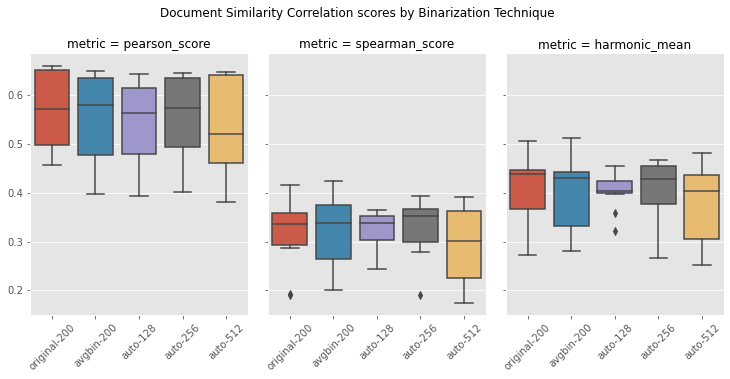

GEval document similarity Pearson's and Speraman's correlations and harmonic mean between them by binarization technique in Figure \ref{fig:geval-docsim-hm}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/geval-docsim-hm.png}}
    \caption{GEval Document Similarity Pearson's and Speraman's correlations and harmonic mean between them by Binarization Technique}
    \label{fig:geval-docsim-hm}
\end{figure}


In [28]:
g = sns.catplot(
    data=df[
        (df['task_name']=='DocumentSimilarity') 
        & (df['model']=='with_weights')
        & (df['coverage']>=0.5)
    ], 
    x="embedding_variant", 
    y="score_value",
    kind="box",
    aspect=0.7,
    col="metric",
    order=["original-200", "avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Document Similarity Correlation scores by Binarization Technique")
g.set_xticklabels(rotation=45)

plt.savefig("images/geval-docsim-hm.png")

plt.show()

print("GEval document similarity Pearson's and Speraman's correlations and harmonic mean between them by binarization technique in Figure \\ref{fig:geval-docsim-hm}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/geval-docsim-hm.png}}")
print("    \caption{GEval Document Similarity Pearson's and Speraman's correlations and harmonic mean between them by Binarization Technique}")
print("    \label{fig:geval-docsim-hm}")
print("\end{figure}")

In [29]:
def get_latex_table_docsim_harm_mean(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_docsim_bestscores[df_docsim_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).sort_values(by="original-200", ascending=False).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-docsim-hm-{gold_standard_file_lower}",
        caption=f"Harmonic Mean scores for best model of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

In [30]:
gold_standard_file = "LP50"

dataset_lower = str.lower(gold_standard_file).replace("_", "-")

print("Harmonic mean between Pearson's and Speraman's correlations for "+gold_standard_file+" Dataset in table \\ref{tab:geval-docsim-hm-"+dataset_lower+"}.\n\n")


print(get_latex_table_docsim_harm_mean(gold_standard_file))

Harmonic mean between Pearson's and Speraman's correlations for LP50 Dataset in table \ref{tab:geval-docsim-hm-lp50}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransR               &         0.506  &	\textbf{0.511} &     0.439  &     0.466  &     0.481  \\
RotatE               &         0.458  &       0.441  &     0.397  &     0.450  &	\textbf{0.459} \\
TransE-L2            &	\textbf{0.447} &       0.443  &     0.402  &     0.435  &     0.430  \\
DistMult             &	\textbf{0.445} &       0.380  &     0.402  &     0.401  &     0.408  \\
ComplEx              &         0.442  &       0.442  &     0.417  &	\textbf{0.463} &     0.397  \\
TransE-L1            &         0.435  &       0.418  &     0.407  &     0.421  &	\textbf{0.439} \\
RESCAL               &         0.408  &	\textbf{0.484} &     0.427  &     0.456  &     0.266  \\
RDF2vec$_{CBOW}$     &         0.352  &       0.316  &	\

## Entity Relatedness

In [31]:
df_entrel = df[
    (df['task_name']=='EntityRelatedness') 
    & (df['coverage']>=0.5)
].drop(columns=['test_name'])
df_entrel['rank'] = df_entrel.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_entrel_bestscores = df_entrel[df_entrel['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_entrel_bestscores['gold_standard_file'].unique()

array(['KORE'], dtype=object)

In [32]:
df_entrel_bestscores

,gold_standard_file,coverage,model,model_configuration,metric,score_value,test_name_short,embedding_type,embedding_variant
333,KORE,1.000000,-,-,kendalltau_correlation,0.419048,rdf2vec-sg-oa-200-original,RDF2vec$_{SG-OA}$,original-200
377,KORE,1.000000,-,-,kendalltau_correlation,0.401504,rdf2vec-sg-oa-512-autoencoded,RDF2vec$_{SG-OA}$,auto-512
366,KORE,1.000000,-,-,kendalltau_correlation,0.376441,rdf2vec-sg-oa-256-autoencoded,RDF2vec$_{SG-OA}$,auto-256
344,KORE,1.000000,-,-,kendalltau_correlation,0.347870,rdf2vec-sg-oa-200-avgbin,RDF2vec$_{SG-OA}$,avgbin-200
355,KORE,1.000000,-,-,kendalltau_correlation,0.343860,rdf2vec-sg-oa-128-autoencoded,RDF2vec$_{SG-OA}$,auto-128
374,KORE,1.000000,-,-,kendalltau_correlation,0.313283,rdf2vec-cbow-512-autoencoded,RDF2vec$_{CBOW}$,auto-512
341,KORE,1.000000,-,-,kendalltau_correlation,0.310777,rdf2vec-cbow-200-avgbin,RDF2vec$_{CBOW}$,avgbin-200
352,KORE,1.000000,-,-,kendalltau_correlation,0.297744,rdf2vec-cbow-128-autoencoded,RDF2vec$_{CBOW}$,auto-128
363,KORE,1.000000,-,-,kendalltau_correlation,0.296241,rdf2vec-cbow-256-autoencoded,RDF2vec$_{CBOW}$,auto-256
330,KORE,1.000000,-,-,kendalltau_correlation,0.289724,rdf2vec-cbow-200-original,RDF2vec$_{CBOW}$,original-200


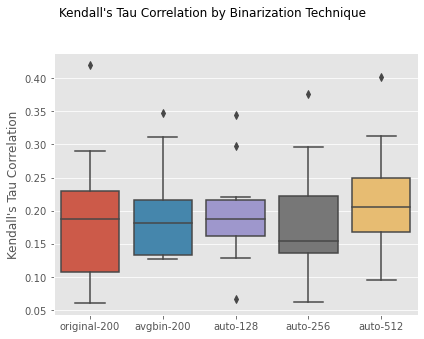

GEval entity relatedness Kendall's tau correlation by binarization technique in Figure \ref{fig:geval-entrel-tau}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.05\linewidth]{assets/geval-entrel-tau.png}}
    \caption{GEval Entity Relatedness Kendall's Tau Correlation by Binarization Technique}
    \label{fig:geval-entrel-tau}
\end{figure}


In [33]:
g = sns.catplot(
    data=df_entrel_bestscores, 
    x="embedding_variant", 
    y="score_value",
    kind="box",
    aspect=1.2,
    order=["original-200", "avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Kendall's Tau Correlation")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Kendall's Tau Correlation by Binarization Technique")

plt.savefig("images/geval-entrel-tau.png")

plt.show()
    
print("GEval entity relatedness Kendall's tau correlation by binarization technique in Figure \\ref{fig:geval-entrel-tau}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.05\linewidth]{assets/geval-entrel-tau.png}}")
print("    \caption{GEval Entity Relatedness Kendall's Tau Correlation by Binarization Technique}")
print("    \label{fig:geval-entrel-tau}")
print("\end{figure}")

In [34]:
def get_latex_table_entrel_tau(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_entrel_bestscores[df_entrel_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).sort_values(by="original-200", ascending=False).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-entrel-tau-{gold_standard_file_lower}",
        caption=f"Kendall's Tau correlation scores for each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

In [35]:
gold_standard_file = "KORE"

dataset_lower = str.lower(gold_standard_file).replace("_", "-")

print("Kendall's Tau correlation for "+gold_standard_file+" Dataset in table \\ref{tab:geval-entrel-tau-"+dataset_lower+"}.\n\n")


print(get_latex_table_entrel_tau(gold_standard_file))

Kendall's Tau correlation for KORE Dataset in table \ref{tab:geval-entrel-tau-kore}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{SG-OA}$    &	\textbf{0.419} &       0.348  &     0.344  &     0.376  &     0.402  \\
RDF2vec$_{CBOW}$     &         0.290  &       0.311  &     0.298  &     0.296  &	\textbf{0.313} \\
ComplEx              &	\textbf{0.234} &       0.218  &     0.211  &     0.204  &     0.217  \\
TransR               &         0.227  &       0.213  &     0.222  &     0.241  &	\textbf{0.269} \\
RDF2vec$_{SG}$       &	\textbf{0.189} &       0.182  &     0.180  &     0.186  &     0.187  \\
RESCAL               &         0.188  &       0.183  &     0.168  &     0.139  &	\textbf{0.229} \\
DistMult             &         0.130  &       0.138  &     0.188  &     0.155  &	\textbf{0.206} \\
RDF2vec$_{CBOW-OA}$  &         0.121  &       0.128  &     0.128  &	\textbf{0.134} &     

## Semantic Analogies

In [36]:
df_semana = df[
    (df['task_name']=='SemanticAnalogies') 
    & (df['coverage']>=0.5)
].drop(columns=['test_name'])
df_semana['rank'] = df_semana.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_semana_bestscores = df_semana[df_semana['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_semana_bestscores['gold_standard_file'].unique()

array(['currency-entities', 'city-state-entities',
       'capital-country-entities', 'all-capital-country-entities'],
      dtype=object)

In [37]:
def get_acc_loss(gold_standard_file, score_value, embedding_type):
    p = df_semana_bestscores[
        (df_semana_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_semana_bestscores["embedding_type"]==embedding_type)
        & (df_semana_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return p - score_value


def calculate_pvalue_semana(gold_standard_file, score_value, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*score_value)

    p = get_acc_loss(gold_standard_file, score_value, embedding_type) + score_value

    return binomtest(successes, n, p, alternative='less').pvalue
    
df_semana_bestscores["acc_loss"] = df_semana_bestscores.apply(
    lambda x: get_acc_loss(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_semana_bestscores["pvalue_worse_than_original"] = df_semana_bestscores.apply(
    lambda x: calculate_pvalue_semana(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_semana_bestscores["not_worse_than_original"] = df_semana_bestscores["pvalue_worse_than_original"] >= alpha

df_semana_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,1.600000e+02,160.000000
mean,5.435359e-02,0.192157
std,1.724291e-01,0.140693
min,0.000000e+00,-0.032178
25%,1.199378e-12,0.083924
50%,2.922101e-05,0.181818
75%,1.522185e-02,0.262355
max,9.306922e-01,0.585920


In [38]:
caption = "Count of GEval Semantic Analogies datasets in which the best model " + \
    "of each binary embedding variant did not significantly underperfom the original one in precision@10. " + \
    "The closer to 4, the less is the performance loss. $\\alpha=0.05$."

df_semana_sig_not_worst = pd.pivot_table(
    df_semana_bestscores[df_semana_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
)

print(caption)
print(r"in table \ref{tab:geval-semana-p-at-10-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_semana_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-semana-p-at-10-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_semana_sig_not_worst.mean())

df_semana_sig_not_worst

Count of GEval Semantic Analogies datasets in which the best model of each binary embedding variant did not significantly underperfom the original one in precision@10. The closer to 4, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-semana-p-at-10-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
	\textbf{ComplEx} &	\textbf{0} &	\textbf{0} &	\textbf{0} &	\textbf{0} \\
DistMult             &	\textbf{1} &	\textbf{1} &	\textbf{1} &	\textbf{1} \\
	\textbf{RDF2vec$_{CBOW-OA}$} &	\textbf{0} &	\textbf{0} &	\textbf{0} &	\textbf{0} \\
	\textbf{RDF2vec$_{CBOW}$} &	\textbf{0} &	\textbf{0} &	\textbf{0} &	\textbf{0} \\
RDF2vec$_{SG-OA}$    &	\textbf{1} &         0  &         0  &	\textbf{1} \\
RESCAL               &	\textbf{3} &         2  &         2  &         2  \\
RotatE               &           1  &         1  &         1  &	\textbf{2} \\
TransE-L1            &       

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
ComplEx,0,0,0,0
DistMult,1,1,1,1
RDF2vec$_{CBOW-OA}$,0,0,0,0
RDF2vec$_{CBOW}$,0,0,0,0
RDF2vec$_{SG-OA}$,0,0,1,1
RESCAL,2,2,2,3
RotatE,1,1,2,1
TransE-L1,0,0,1,0
TransE-L2,0,0,1,1


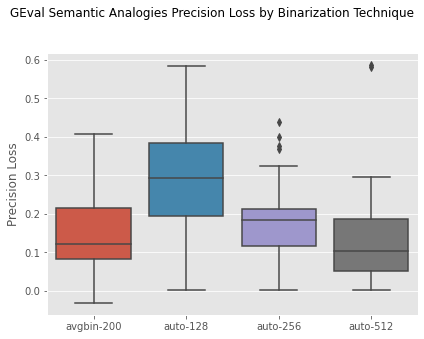

GEval semantic analogies precision loss by binarization technique in Figure \ref{fig:geval-semana-p-loss}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-semana-p-loss.png}}
    \caption{GEval Semantic Analogies Precision Loss by Binarization Technique}
    \label{fig:geval-semana-p-loss}
\end{figure}


In [39]:
g = sns.catplot(
    data=df_semana_bestscores[df_semana_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Precision Loss")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('GEval Semantic Analogies Precision Loss by Binarization Technique')

plt.savefig("images/geval-semana-p-loss.png")

plt.show()
    
print("GEval semantic analogies precision loss by binarization technique in Figure \\ref{fig:geval-semana-p-loss}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-semana-p-loss.png}}")
print("    \caption{GEval Semantic Analogies Precision Loss by Binarization Technique}")
print("    \label{fig:geval-semana-p-loss}")
print("\end{figure}")

In [40]:
def get_latex_table_semana(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_semana_bestscores[df_semana_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).sort_values(by="original-200", ascending=False).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-semana-p-at-10-{gold_standard_file_lower}",
        caption=f"Precision at 10 scores for best model of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

\subsubsection{currency-entities Dataset}
\label{subsubsec:geval-results-semana-currency-entities} 

GEval Semantic Analogies Precision Loss for currency-entities Dataset in Figure \ref{fig:geval-semana-p-loss-currency-entities}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-semana-p-loss-currency-entities.png}
    \caption{GEval Semantic Analogies Precision Loss for currency-entities Dataset}
    \label{fig:geval-semana-p-loss-currency-entities}
\end{figure}



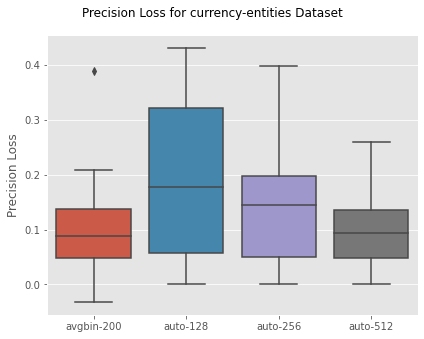

Precision scores for currency-entities Dataset in table \ref{tab:geval-semana-p-at-10-currency-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{0.743} &       0.642  &     0.439  &     0.589  &     0.632  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.637} &       0.544  &     0.441  &     0.448  &     0.533  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.582} &       0.374  &     0.195  &     0.378  &     0.322  \\
TransE-L1            &	\textbf{0.504} &       0.114  &     0.073  &     0.105  &     0.273  \\
RDF2vec$_{CBOW}$     &	\textbf{0.488} &       0.338  &     0.160  &     0.287  &     0.343  \\
TransR               &	\textbf{0.308} &       0.231  &     0.148  &     0.173  &     0.246  \\
ComplEx              &	\textbf{0.101} &       0.017  &     0.004  &     0.023  &     0.017  \\
RESCAL               &         0.079  &	\textbf{0.111} &     0.056  &     0.040  &  

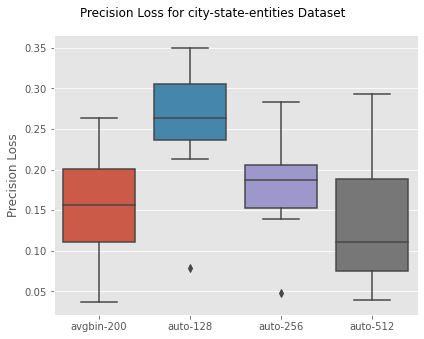

Precision scores for city-state-entities Dataset in table \ref{tab:geval-semana-p-at-10-city-state-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{SG-OA}$    &	\textbf{0.738} &       0.603  &     0.502  &     0.455  &     0.512  \\
TransR               &	\textbf{0.620} &       0.419  &     0.383  &     0.432  &     0.520  \\
TransE-L1            &	\textbf{0.610} &       0.432  &     0.373  &     0.471  &     0.541  \\
RDF2vec$_{CBOW}$     &	\textbf{0.596} &       0.485  &     0.246  &     0.385  &     0.474  \\
TransE-L2            &	\textbf{0.590} &       0.480  &     0.281  &     0.354  &     0.387  \\
ComplEx              &	\textbf{0.578} &       0.315  &     0.252  &     0.388  &     0.437  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.568} &       0.369  &     0.277  &     0.391  &     0.275  \\
DistMult             &	\textbf{0.541} &       0.278  &     0.251  &     0.355  &

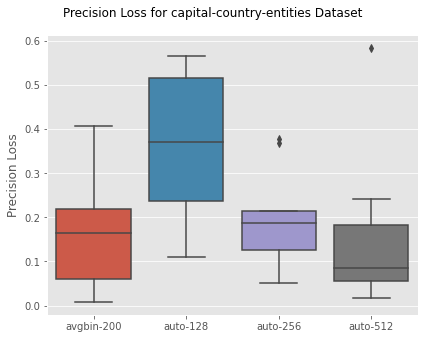

Precision scores for capital-country-entities Dataset in table \ref{tab:geval-semana-p-at-10-capital-country-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransE-L2            &	\textbf{1.000} &       0.957  &     0.775  &     0.949  &     0.982  \\
TransR               &	\textbf{1.000} &       0.915  &     0.889  &     0.933  &     0.962  \\
ComplEx              &	\textbf{0.994} &       0.725  &     0.470  &     0.800  &     0.927  \\
TransE-L1            &	\textbf{0.994} &       0.943  &     0.698  &     0.812  &     0.939  \\
DistMult             &	\textbf{0.988} &       0.775  &     0.545  &     0.836  &     0.927  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.986} &       0.854  &     0.749  &     0.609  &     0.804  \\
RDF2vec$_{CBOW}$     &	\textbf{0.909} &       0.690  &     0.346  &     0.542  &     0.727  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.907} &       0.500  &     0.342  &   

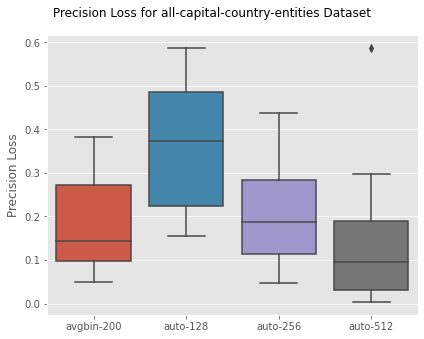

Precision scores for all-capital-country-entities Dataset in table \ref{tab:geval-semana-p-at-10-all-capital-country-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
TransR               &	\textbf{0.971} &       0.914  &     0.806  &     0.925  &     0.968  \\
TransE-L2            &	\textbf{0.968} &       0.919  &     0.603  &     0.800  &     0.931  \\
ComplEx              &	\textbf{0.968} &       0.782  &     0.586  &     0.858  &     0.940  \\
TransE-L1            &	\textbf{0.961} &       0.863  &     0.641  &     0.753  &     0.907  \\
DistMult             &	\textbf{0.960} &       0.740  &     0.578  &     0.877  &     0.929  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.944} &       0.844  &     0.788  &     0.683  &     0.809  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.852} &       0.471  &     0.267  &     0.561  &     0.266  \\
RotatE               &	\textbf{0.808} &       0.518  &     0.2

In [41]:
for gold_standard_file in df_semana_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-semana-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_semana_bestscores[
            (df_semana_bestscores["embedding_variant"]!="original-200")
            & (df_semana_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Precision Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Precision Loss for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-semana-p-loss-{dataset_lower}.png")

    print("GEval Semantic Analogies Precision Loss for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-semana-p-loss-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-semana-p-loss-"+dataset_lower+".png}")
    print("    \caption{GEval Semantic Analogies Precision Loss for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-semana-p-loss-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("Precision scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-semana-p-at-10-"+dataset_lower+"}.\n\n")


    print(get_latex_table_semana(gold_standard_file))